# Tutorial: Learning Model Predictive Robustness using Gaussian Process Regression

This tutorial provides how to learn the model predictive robustness for online application using Gaussian Process (GP) regression.

Our simulation is based on [CommonRoad](commonroad.in.tum.de), and [GPyTorch](gpytorch.ai) is used to model and solve the GP regression.

# Preparation
We now support the predicates used in the formalized traffic rule for German interstates. As a result, the German Highway Drone (highD) Dataset is used for training the GP model.

To download the whole raw highD dataset, please go to the [homepage](https://www.highd-dataset.com). We provide a converter to convert the highD dataset into CommonRoad scenarios in `.xml` format.
The public converter is available [here](https://commonroad.in.tum.de/tools/dataset-converters). Please save the converted scenarios under `./scenarios`.

For instance, the following command can be used:

```
$ python -m src.main highD input_dir ./commonroad-model-predictive-robustness/scenarios/ --num_processes 4 --keep_ego
```

## Set up configuration

In [1]:
from commonroad_mpr.utils.configuration_builder import ConfigurationBuilder as Cfg

Cfg.build_configuration(config_profile="tutorial")


# Generation of data
Data is generated based on the configuration files. After the data is generated, you can find the corresponding csv file under `./output/tutorial/learning_data` at default.

The following feature variables are used:

In [2]:
import warnings

warnings.filterwarnings("ignore")

from commonroad_mpr.learning import FeatureExtrator
import json

print(json.dumps(FeatureExtrator.all_valid_features, indent=4))


{
    "1": [
        "position",
        "velocity",
        "acceleration",
        "jerk",
        "jerk_dot",
        "lateral_position",
        "orientation",
        "curvature",
        "curvature_dot",
        "curvature_ddot",
        "length",
        "width",
        "min_distance_to_road_left",
        "distance_to_road_left",
        "max_distance_to_road_left",
        "min_distance_to_road_right",
        "distance_to_road_right",
        "max_distance_to_road_right",
        "distance_to_road",
        "distance_to_road_min",
        "min_distance_to_ref_lane_left",
        "distance_to_ref_lane_left",
        "max_distance_to_ref_lane_left",
        "min_distance_to_ref_lane_right",
        "distance_to_ref_lane_right",
        "max_distance_to_ref_lane_right",
        "distance_to_ref_lane",
        "distance_to_ref_lane_min",
        "min_distance_to_occ_lanes_left",
        "distance_to_occ_lanes_left",
        "max_distance_to_occ_lanes_left",
        "min_distance

In [3]:
from commonroad_mpr.learning import DataGenerator

generator = DataGenerator.create_from_config(save_filename="tutorial.csv")

# with multiple threads or without
generator.generate_data_parallel()  # or generator.generate_data()


# Training the GP model
Load the data and train the GP model. All the trained model is saved in `./output/tutorial/models`. If you currently don't have the highD dataset, we also provide you an exemplary model under `/tutorials/model/` with smaller data size.

In [4]:
from commonroad_mpr.learning import DataLoader
from commonroad_mpr.learning import ModelTrainer
import os

# here we directly use the exemplary `tutorial.csv` under `tutorials/model/`
root_dir = os.path.dirname(Cfg["path"]["path_root"])
data_loader = DataLoader.create_from_config(
    load_filepath=os.path.join(root_dir, "tutorials/data/tutorial.csv")
)
model_trainer = ModelTrainer.create_from_config(data_loader=data_loader)
model_trainer.train()


# Optional: Evaluating the model
Evaluate the generated GP model (under `/output/tutorial/models`)


The Mean Square prediction Error: {
    "cut_in": 1.694154519254557e-05,
    "in_same_lane": 7.521162436787417e-06,
    "keeps_safe_distance_prec": 8.474565114804614e-05,
    "in_front_of": 4.5883066654530685e-05,
    "single_lane": 2.941257569098888e-11,
    "keeps_lane_speed_limit": 9.176001323572456e-11,
    "keeps_fov_speed_limit": 1.9922538085292747e-11,
    "keeps_type_speed_limit": 1.9922538085292747e-11,
    "keeps_brake_speed_limit": 1.0985094686915224e-11,
    "brakes_abruptly_relative": 1.7214552214624963e-06,
    "brakes_abruptly": 1.7054321350124788e-11
}


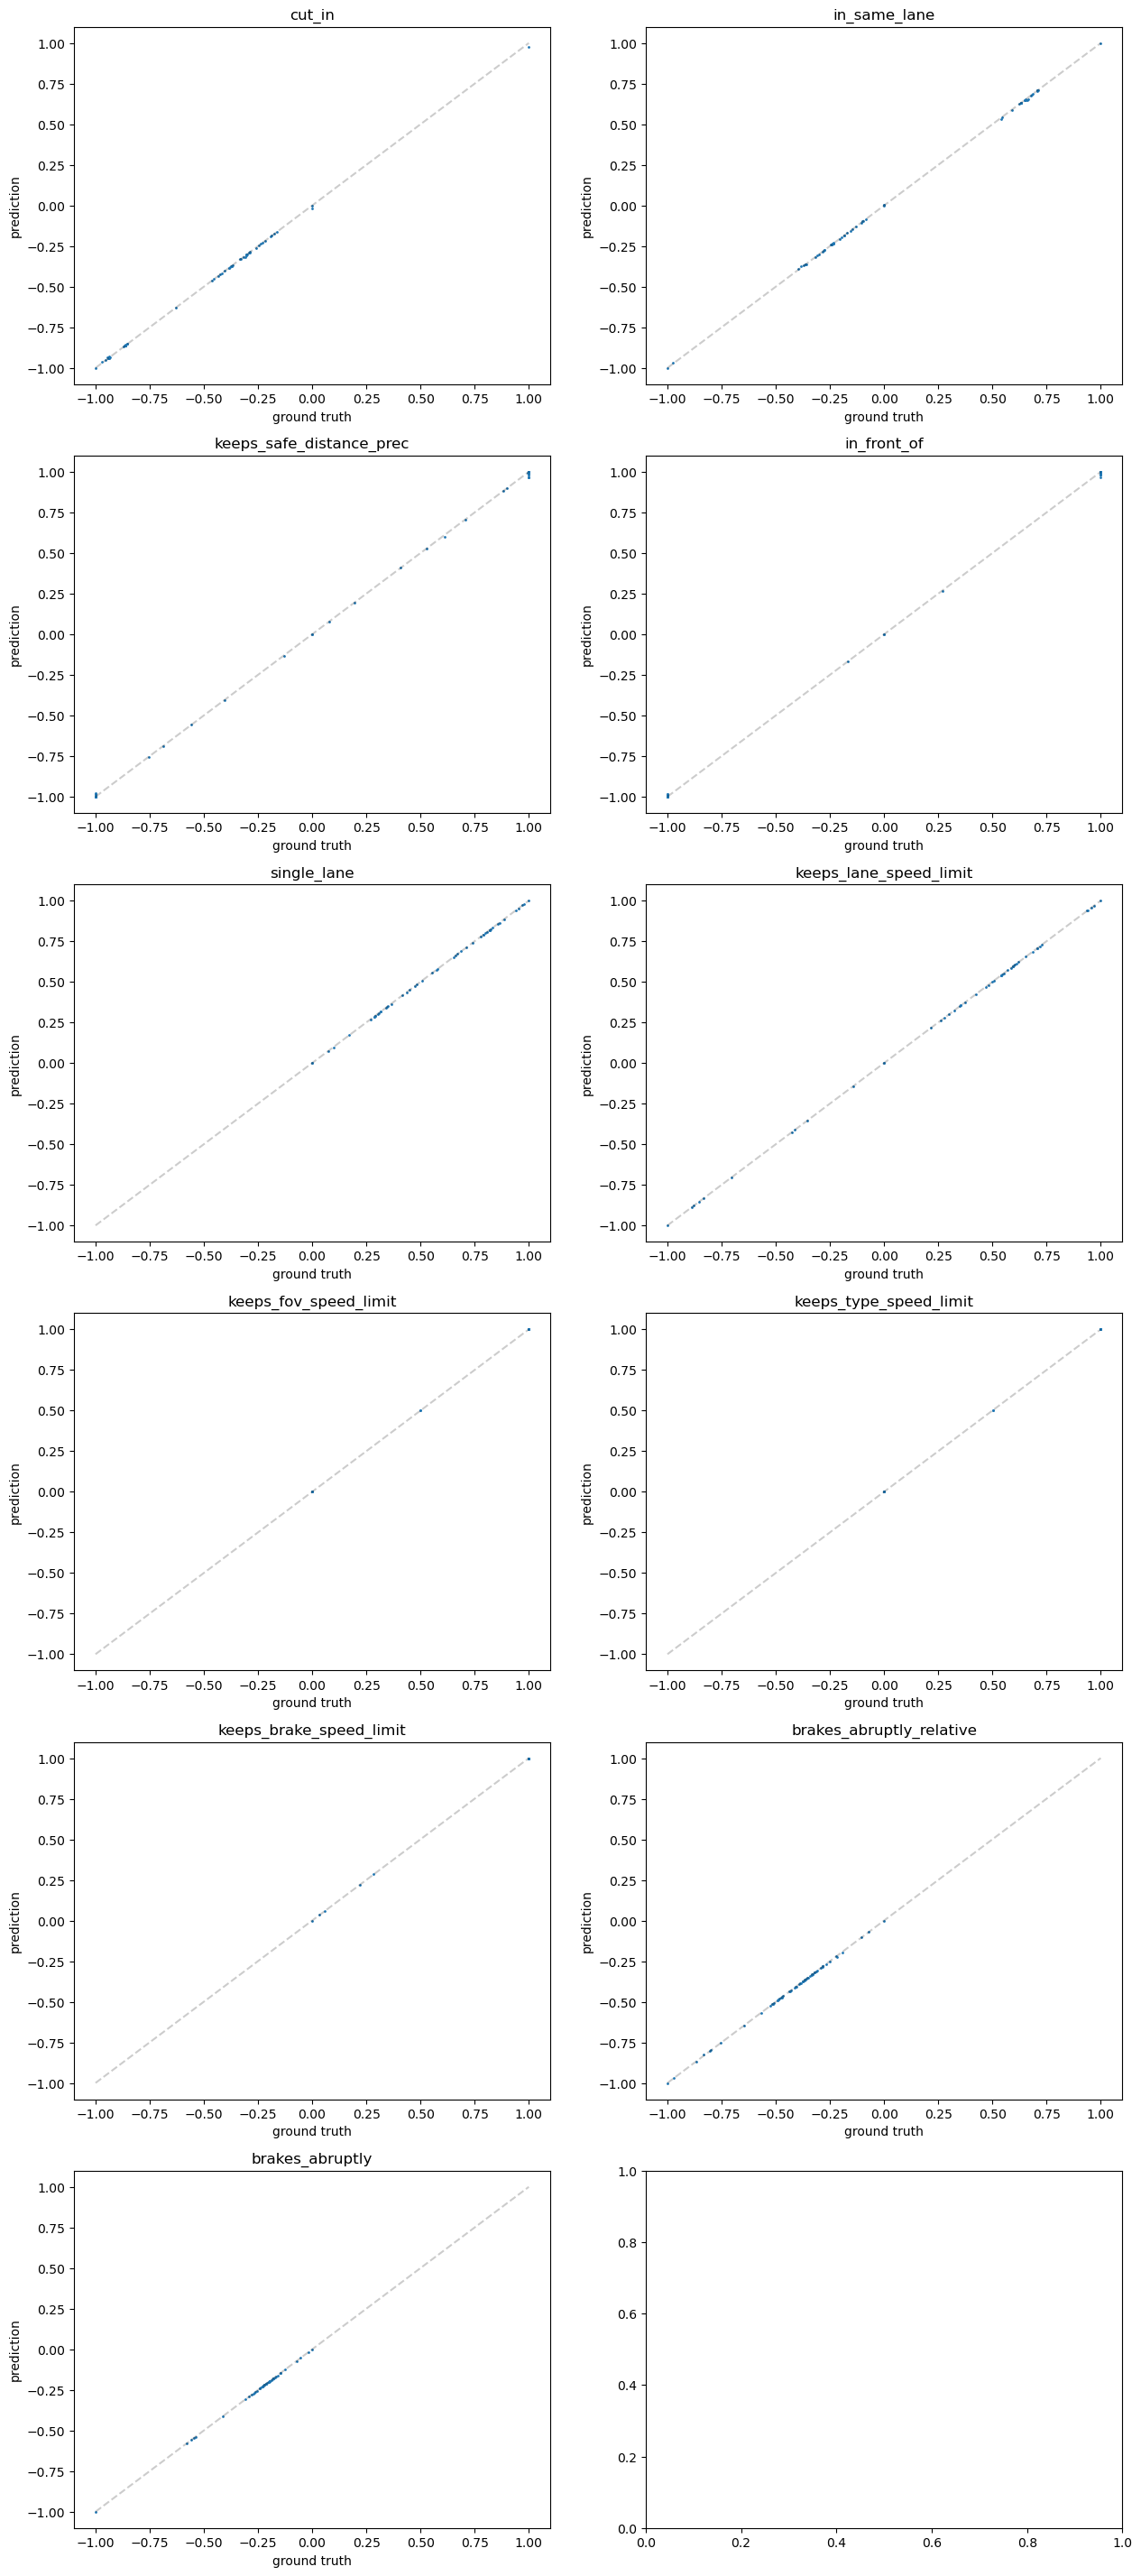

In [5]:
from commonroad_mpr.learning import ModelEvaluator

model_evaluator = ModelEvaluator.create_from_config(data_loader=data_loader)
fig, axs, mse = model_evaluator.evaluate()
print("The Mean Square prediction Error:", json.dumps(mse, indent=4))


# Evaluating the robustness for online usages
the mean value is used as the robustness and the uncertainty measure is also provided

In [12]:
from commonroad_mpr.common import ScenarioReader
from commonroad_mpr.learning import PredicateEvaluatorML
import warnings

warnings.filterwarnings("ignore")

scenario_id = "DEU_Muc-4_2_T-1"
world_state = ScenarioReader.read_scenario(scenario_id)
ego_vehicle = world_state.vehicle_by_id(202)
other_vehicle = world_state.vehicle_by_id(203)
time_step = 10
peml = PredicateEvaluatorML(["in_same_lane"])

rob, std = peml.evaluate_robustness(
    world_state=world_state,
    vehicles=[ego_vehicle, other_vehicle],
    time_step=time_step,
)
print(f"The MPR is {rob[0]: .2f} with the standard deviation of: {std[0]: .2f}")


KeyError: 200